In [269]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder

In [ ]:
num_bits = 5
intensity_bits =  3

In [271]:
image = np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]

])

In [272]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='GradX')
grad2 = QuantumRegister(intensity_bits, name='GradY')
grad_diag = QuantumRegister(intensity_bits, name='GradDiag')
grad2c = QuantumRegister(1, name='GradYc')
grad_diag_c = QuantumRegister(1, name='GradDiagC')
grad_sum_c = QuantumRegister(1, name='GradSumC')
anc = QuantumRegister(1, name='a')
anc2 = QuantumRegister(1, name = 'a2')
anc3 = QuantumRegister(1, name = 'a3')
oracle_a = QuantumRegister(1, name = 'oracle_a')
cr = ClassicalRegister(num_bits*2 + 1, name='c')

qc = QuantumCircuit(x, y, i1, i2, grad1, grad2, grad2c, grad_diag, grad_diag_c,grad_sum_c, anc, anc2, anc3, oracle_a, cr)


In [273]:
qc.h(x)
qc.h(y)
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=23, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "x"), index=0>, <Qubit register=(3, "x"), index=1>, <Qubit register=(3, "x"), index=2>, <Qubit register=(3, "y"), index=0>, <Qubit register=(3, "y"), index=1>, <Qubit register=(3, "y"), index=2>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(2, "GradY"), index=0>, <Qubit register=(2, "GradY"), index=1>, <Qubit register=(1, "GradYc"), index=0>, <Qubit register=(2, "GradDiag"), index=0>, <Qubit register=(2, "GradDiag"), index=1>, <Qubit register=(1, "GradDiagC"), index=0>, <Qubit register=(1, "GradSumC"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "a3"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), cl

In [274]:
neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))


In [275]:
# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

In [276]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
ladder_down = ladder.inverse()


In [277]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])

In [278]:
sub1 = subtract(i1, grad1, anc)
qc.append(sub1, list(i1) + list(grad1) + list(anc))

In [279]:
neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [280]:
ladder_down = ladder.inverse()
qc.append(ladder, list(y))

In [281]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))

In [282]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad_diag[i])

In [283]:
qc.append(sub1, list(i1) + list(grad_diag) + list(anc3))

In [284]:
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [285]:
qc.append(ladder_down,list(x))
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
qc.append(ladder_down,list(y))


In [286]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad2[i])

In [287]:
qc.append(sub1, list(i1) + list(grad2) + list(anc2))


In [288]:
add = qft_adder(grad1,grad2,grad2c)
qc.append(add, list(grad1) + list(grad2) + list(grad2c))

In [289]:
add2 = qft_adder(list(grad2)+list(grad2c),list(grad_diag)+list(grad_diag_c),grad_sum_c)
qc.append(add2, list(grad2)+list(grad2c)+list(grad_diag)+list(grad_diag_c)+list(grad_sum_c))

In [290]:
qc.barrier()
qc.h(oracle_a)

og = filter_oracle("000")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_a) + list(grad_diag)+list(grad_diag_c))

qc.h(oracle_a)

qc.barrier()

3
[0, 0, 0]
2 0
max 2
1 0
0 0


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=23, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "x"), index=0>, <Qubit register=(3, "x"), index=1>, <Qubit register=(3, "x"), index=2>, <Qubit register=(3, "y"), index=0>, <Qubit register=(3, "y"), index=1>, <Qubit register=(3, "y"), index=2>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(2, "GradY"), index=0>, <Qubit register=(2, "GradY"), index=1>, <Qubit register=(1, "GradYc"), index=0>, <Qubit register=(2, "GradDiag"), index=0>, <Qubit register=(2, "GradDiag"), index=1>, <Qubit register=(1, "GradDiagC"), index=0>, <Qubit register=(1, "GradSumC"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "a3"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), cl

In [291]:
qc.measure(list(x) + list(y) + list(oracle_a), list(cr))

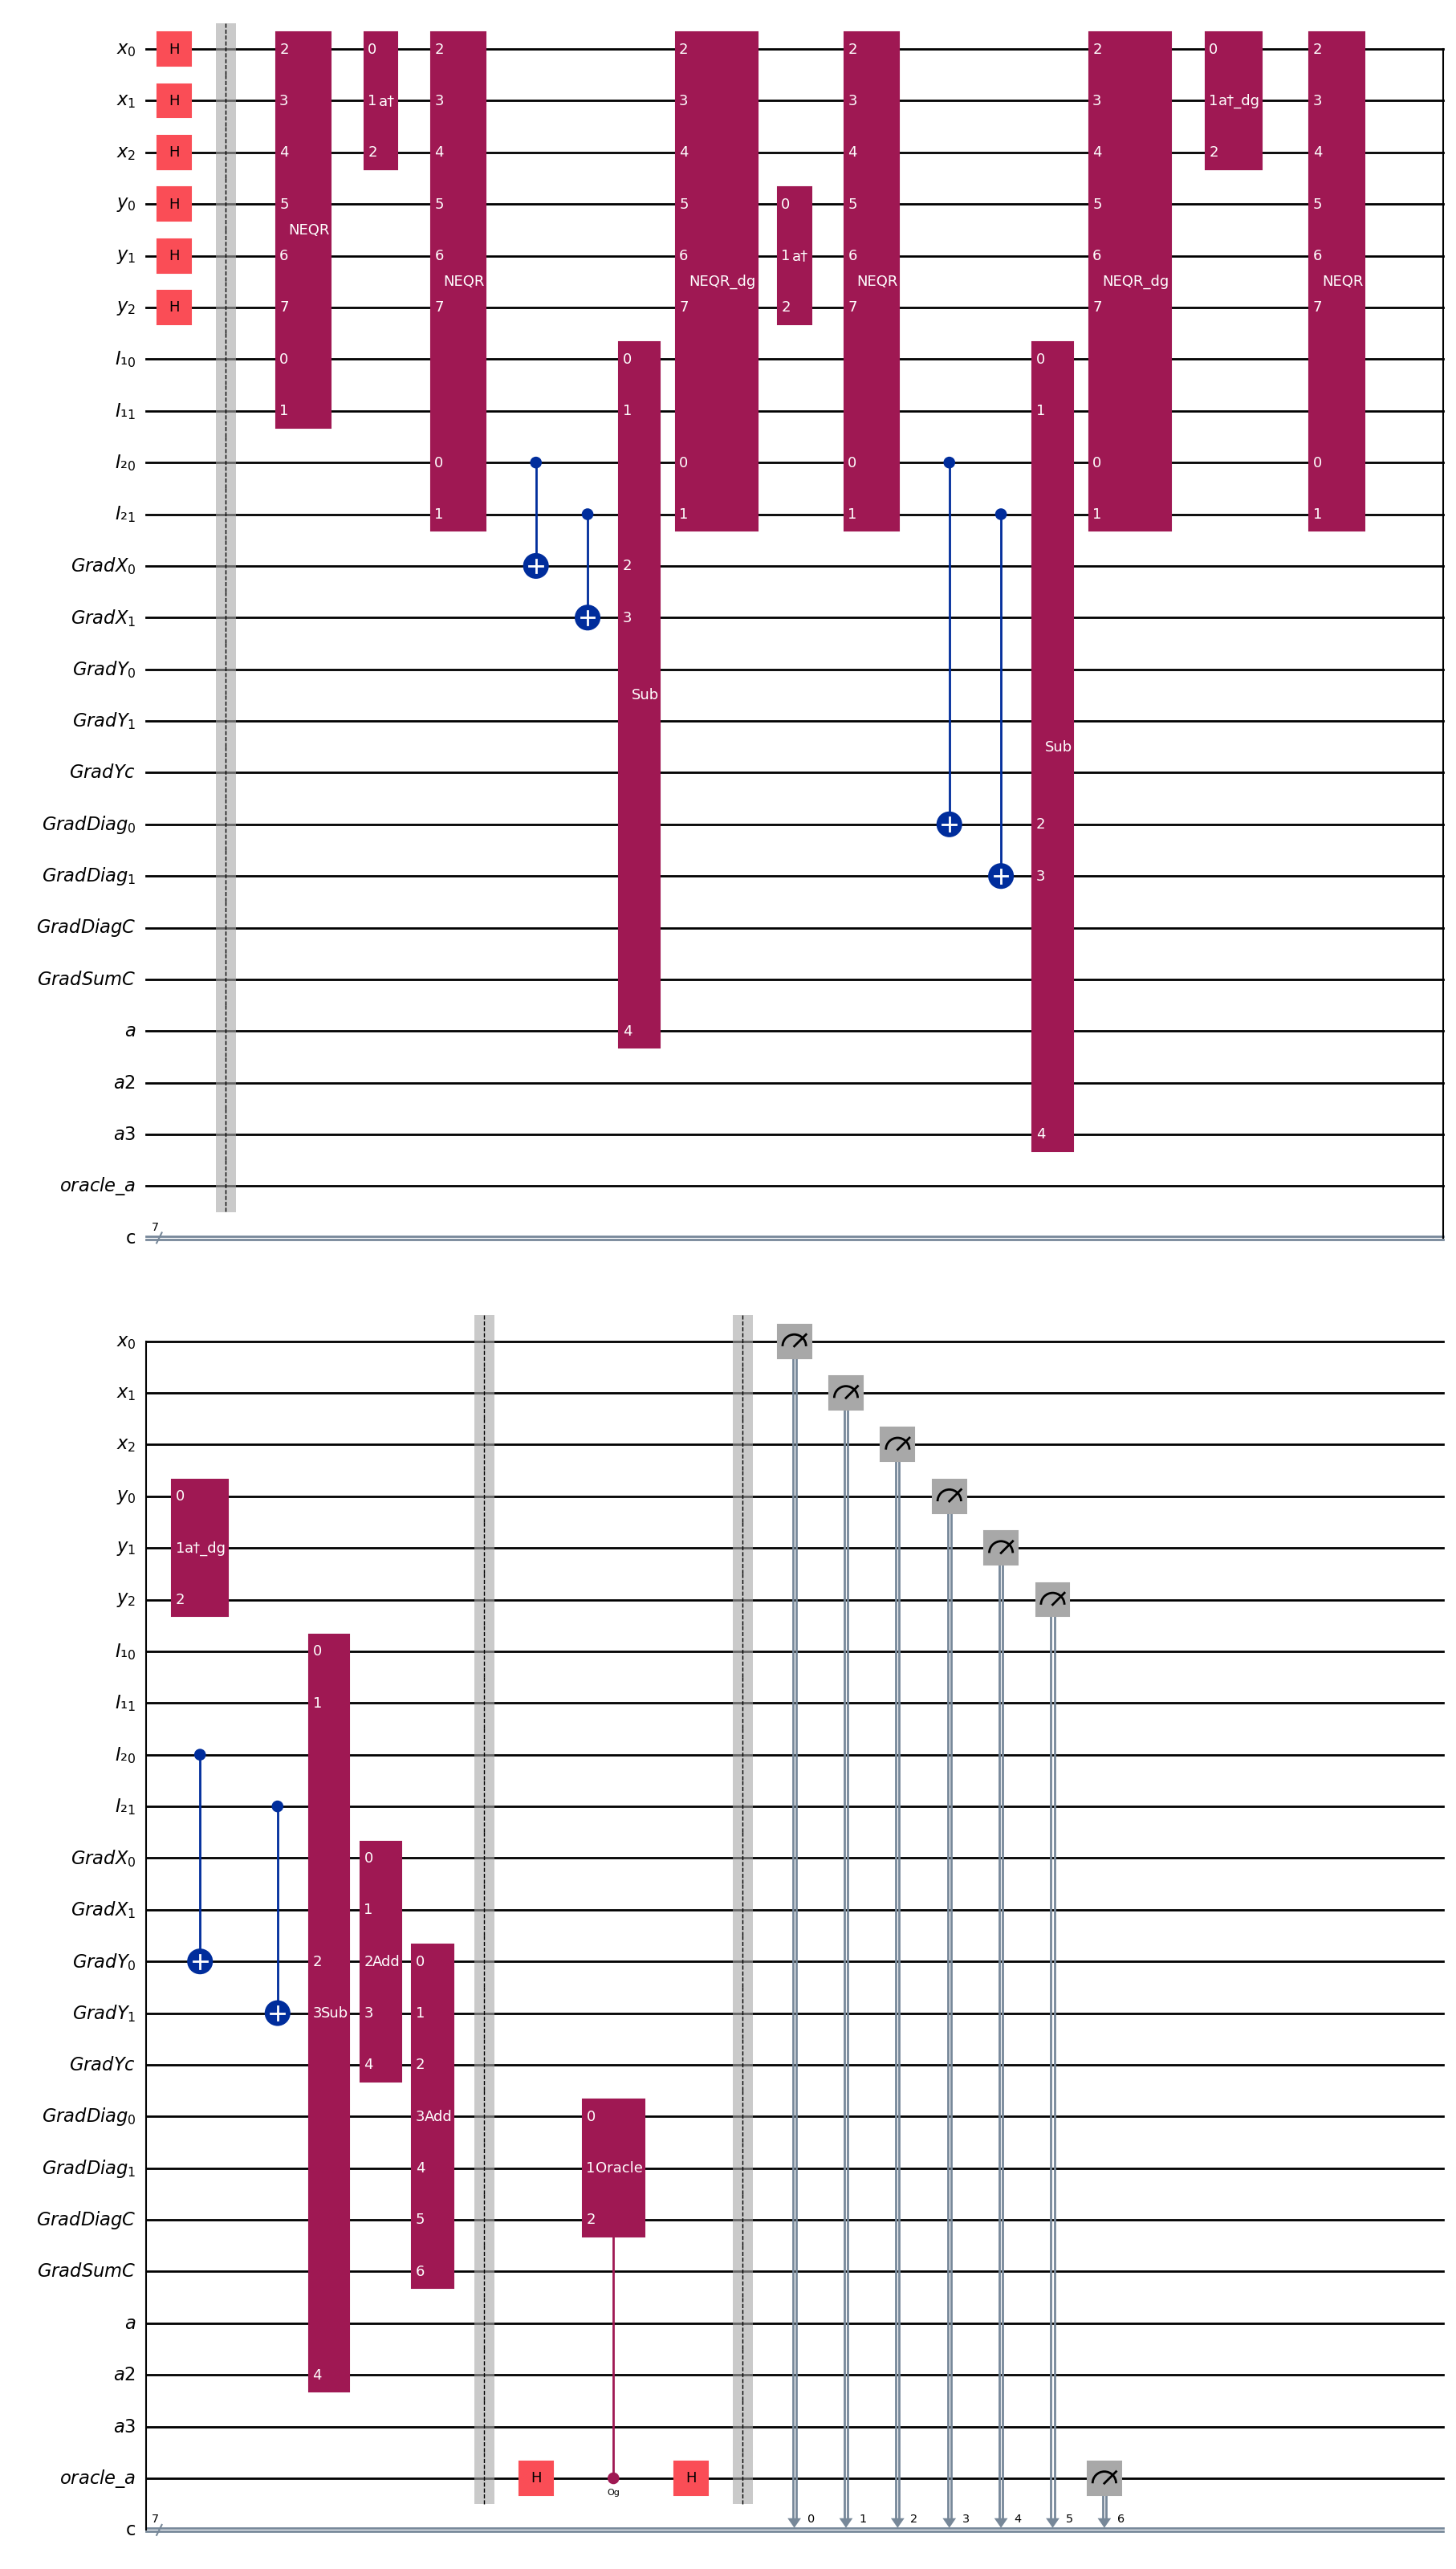

In [292]:
qc.draw('mpl')

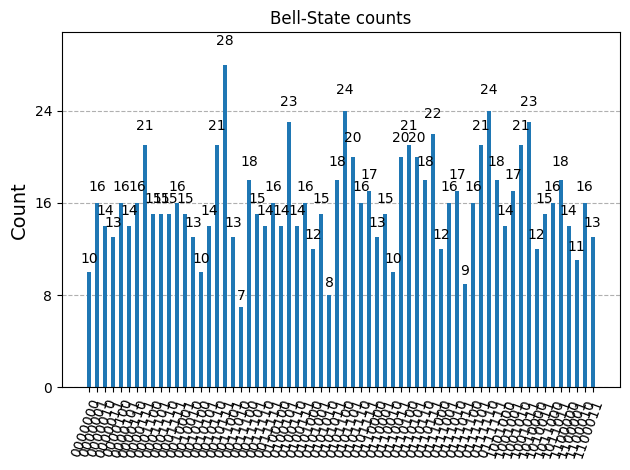

In [293]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [294]:
print(counts.items())

dict_items([('1100011', 13), ('0011111', 16), ('0110000', 13), ('0000111', 21), ('0010111', 28), ('0001111', 16), ('0100110', 14), ('0111010', 17), ('0111001', 16), ('1001000', 14), ('0111100', 16), ('1001011', 23), ('0001101', 15), ('0100100', 14), ('0000001', 16), ('0101010', 8), ('0110110', 18), ('0000100', 16), ('0110011', 20), ('0101101', 20), ('0000011', 13), ('0101100', 24), ('0110100', 21), ('1010011', 15), ('0101001', 15), ('0001100', 15), ('0111101', 21), ('0100101', 23), ('0001110', 15), ('0111011', 9), ('0110101', 20), ('0000010', 14), ('0101011', 18), ('0101111', 17), ('0110001', 15), ('0000110', 16), ('0011110', 14), ('1100000', 14), ('0010100', 10), ('1011000', 16), ('0000000', 10), ('0110111', 22), ('1011011', 18), ('1010000', 12), ('0111000', 12), ('1001001', 17), ('1100001', 11), ('0011101', 15), ('0100111', 16), ('1001010', 21), ('0110010', 10), ('0000101', 14), ('0101110', 16), ('0101000', 12), ('0010001', 15), ('0111110', 24), ('0010101', 14), ('0011100', 18), ('11

In [295]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)  
    y = int(y_bin, 2)
    x = int(x_bin, 2)

    edge_img[y, x] = intensity
print(edge_img)

[[0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
